In [1]:
import os
import json
import glob
from random import sample
import random
import multiprocessing as mproc

import pandas as pd
import numpy as np

from PIL import Image
from tqdm.auto import tqdm
from joblib import Parallel, delayed

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
from torchvision import transforms as T, models
from torchvision.models import resnet18
from torchvision.transforms import ToTensor,Compose, Resize, InterpolationMode

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, RichModelSummary, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

from torchmetrics.classification import BinaryAccuracy, Accuracy
from torchmetrics import MaxMetric, MeanMetric

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import matplotlib.pyplot as plt

import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("Label") 

wandb.login(key=wandb_api)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
# Define seeds for non-stochastic behaviour
random.seed(42)
torch.manual_seed(42)

# Exploratory Analysis

In [3]:
BASE_PATH = '/kaggle/input/UBC-OCEAN'
TRAIN_ANN_PATH = BASE_PATH + "/train.csv"
TILES_PATH = "/kaggle/input/ubc-tiles-224px-mini-3-rdn-imgs"

In [4]:
# Get all file names in the folder
subfolder_names = os.listdir(TILES_PATH)

# Generate the full paths for each file
subfolder_list = [os.path.join(TILES_PATH, folder_name) for folder_name in subfolder_names]

# Print number of images/subfolders
print(f'Number of images/folders: {len(subfolder_list)}')

# Generate a list of lists with image paths for each subfolder
image_paths_list = []

for subfolder in subfolder_list:
    # Get all file names (images) in the subfolder
    image_names = os.listdir(subfolder)
    # Generate full paths for each image in the subfolder
    image_paths = [os.path.join(subfolder, image_name) for image_name in image_names]
    # Add the list of image paths to the main list
    image_paths_list.append(image_paths)

# Print number of images/subfolders
print(f'Number of tiles: {sum(len(sublist) for sublist in image_paths_list)}')

Number of images/folders: 536
Number of tiles: 33093


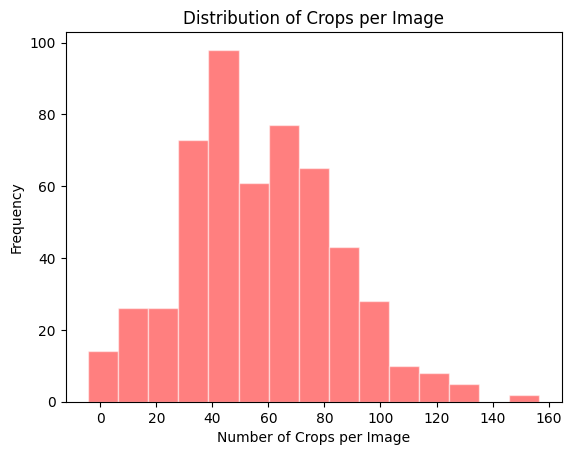

In [5]:
# Extract the number of files per sublist
num_files_per_sublist = [len(sublist) for sublist in image_paths_list]

# Create a histogram
plt.hist(num_files_per_sublist, bins=15, align='left', edgecolor='white', color="r", alpha=0.5)

# Set labels and title
plt.xlabel('Number of Crops per Image')
plt.ylabel('Frequency')
plt.title('Distribution of Crops per Image')

# Display the histogram
plt.show()

In [6]:
# Train annotations overview
train_df = pd.read_csv(TRAIN_ANN_PATH)
train_df.head()

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False


In [7]:
# Visualize some images of the dataset

# Create a dictionary to store image paths for each label
label_crops = {label: [] for label in train_df['label'].unique()}

# Populate the dictionary with image paths
for sublist in image_paths_list:
    for image_path in sublist:
        image_id = int(os.path.basename(image_path).split('_')[1].split('_')[0])
        image_mag = train_df.loc[train_df['image_id'] == image_id, 'is_tma'].iloc[0]
        label = train_df.loc[train_df['image_id'] == image_id, 'label'].iloc[0]
        label_crops[label].append(image_path)

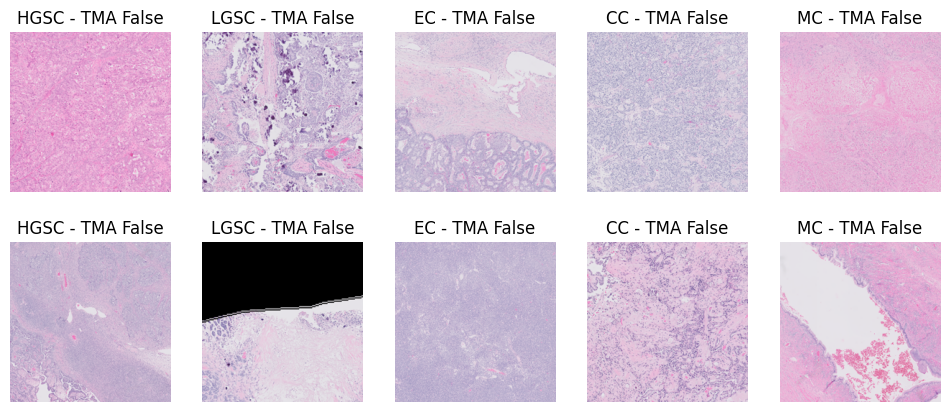

In [8]:
# Create a plot of size (2, 5)
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# Randomly select one crop for each unique label and plot
for i, (label, paths) in enumerate(label_crops.items()):
    for j in range(2):
        random.seed(43+j)
        random_path = random.choice(paths)
        image = plt.imread(random_path)

        # Plot on the corresponding subplot
        axes[j, i % 5].imshow(image)
        axes[j, i % 5].set_title(label + ' - TMA ' + str(image_mag))
        axes[j, i % 5].axis('off')

plt.show()

# Dataset and Datamodule

In [9]:
class UBCDataset(Dataset):
    def __init__(self, root_dir, df, max_images_per_folder=80, mode=None, transform=None):
        self.mode = mode
        self.root_dir = root_dir
        self.df = df
        self.max_images_per_folder = max_images_per_folder
        self.transform = transform
        # Set up labels
        self.labels_unique = sorted(self.df["label"].unique())
        self.num_classes = len(self.labels_unique)
        self.labels_ohe = {lb: i for i, lb in enumerate(self.labels_unique)}
        # Get a list of subfolders and filter them based on the presence of corresponding IDs in the DF
        self.subfolders = [subfolder for subfolder in os.listdir(root_dir) if any(df['image_id'] == int(os.path.basename(subfolder).split('_')[1]))]
        # Generate a list of the image paths
        self.image_paths = self.get_image_paths()
    
    def get_image_paths(self):
        image_paths = []

        for subfolder in self.subfolders:
            subfolder_path = os.path.join(self.root_dir, subfolder)
            # Check if the subfolder exists
            if os.path.exists(subfolder_path) and os.path.isdir(subfolder_path):
                # Get all files in the subfolder
                files = os.listdir(subfolder_path)
                # Shuffle the list of images
                random.shuffle(files)
                # Add up to max_images_per_subfolder to the image_paths list
                for i in range(min(self.max_images_per_folder, len(files))):
                    image_paths.append(os.path.join(subfolder_path, files[i]))

        return image_paths
            
        
    def __len__(self):
        return len(self.image_paths)

    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
            
        # Find label of the image
        image_id = int(os.path.basename(img_path).split('_')[1].split('_')[0])
        label = self.df.loc[self.df['image_id'] == image_id, 'label'].iloc[0]
        label = self.labels_ohe[label]

        return image, label, str(img_path)
    

In [10]:
# Mean and std of tiles dataset for normalization
img_color_mean = [0.7710526428169198, 0.6663220390985661, 0.7657286638869258]
img_color_std = [0.15302981624947548, 0.16400406835169548, 0.14187081063610732]

# Define transforms
transform_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.3),# Add horizontal flips
    T.RandomVerticalFlip(p=0.3),  # Add vertical flips
    T.RandomRotation(degrees=30),  # Add random rotations within ±30 degrees
    T.ToTensor(),
    T.Normalize(img_color_mean, img_color_std),
])

## Other transformations
# T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust color
# T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # Random affine transformations
# (fix) T.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
# (fix) T.RandomGamma(gamma_limit=(10, 25), p=0.5),

transform_val = T.Compose([
    T.Resize((224, 224)), 
    T.ToTensor(),
    T.Normalize(img_color_mean,img_color_std),
])

### Explore dataset

In [11]:
# Create dataset for visualization purposes
dataset = UBCDataset(root_dir=TILES_PATH, df=train_df, mode='train', transform=transform_train)
print(f'Number of tiles in the dataset: {len(dataset)}')

Number of tiles in the dataset: 30766


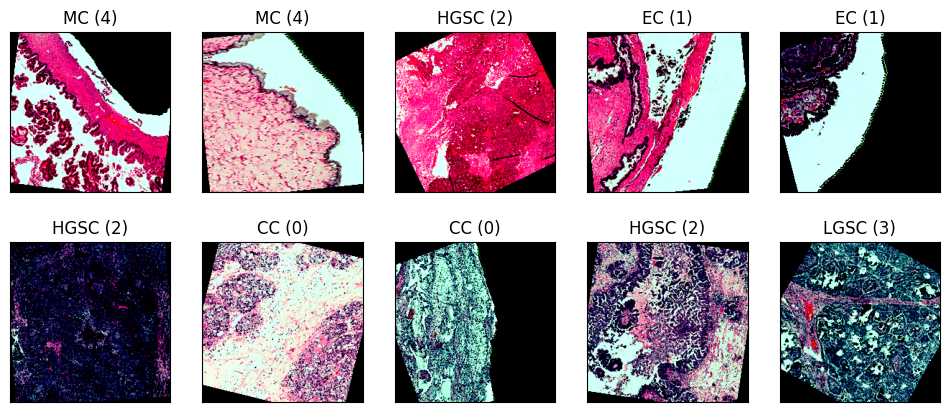

In [12]:
# Visualize some images from the Dataset (change code)
def get_key_by_value(dictionary, target_value):
    for key, value in dictionary.items():
        if value == target_value:
            return key

label_code = {'CC': 0, 'EC': 1, 'HGSC': 2, 'LGSC': 3, 'MC': 4}
images = []
for i in range(1,1001, 100):
    img, lb, path = dataset[i]
    images.append((img, lb))
    
fig = plt.figure(figsize=(12, 5))
for i in range(10):
    img, lb_ohe = images[i]
    lb = get_key_by_value(label_code, lb_ohe)
    img = np.transpose(img, (1, 2, 0))
    ax = fig.add_subplot(2, 5, i % 10 + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(f"{lb} ({lb_ohe})")

In [13]:
'''
# Print bar plot of labels per class
# Initialize counts for each class
class_counts = {label: 0 for label in range(5)}  # Assuming 5 labels

# Count occurrences of each class in the dataset
for _, label, img_path in dataset:
    class_counts[label] += 1

# Extract counts and labels for plotting
counts = list(class_counts.values())
labels = list(class_counts.keys())

# Plot the histogram
plt.bar(labels, counts, align='center')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title(title)
plt.show()
'''

"\n# Print bar plot of labels per class\n# Initialize counts for each class\nclass_counts = {label: 0 for label in range(5)}  # Assuming 5 labels\n\n# Count occurrences of each class in the dataset\nfor _, label, img_path in dataset:\n    class_counts[label] += 1\n\n# Extract counts and labels for plotting\ncounts = list(class_counts.values())\nlabels = list(class_counts.keys())\n\n# Plot the histogram\nplt.bar(labels, counts, align='center')\nplt.xlabel('Class')\nplt.ylabel('Count')\nplt.title(title)\nplt.show()\n"

In [14]:
# Define data module
class UBCDatamodule(pl.LightningDataModule):
    def __init__(self, training_data_path, df, batch_size=64, num_workers=None, train_transforms=None,
        val_transforms = None,
        split_p = 0.2):
        super().__init__()
        self.training_data_path = training_data_path
        self.batch_size = batch_size
        self.num_workers = num_workers or mproc.cpu_count()
        self.split_p = split_p
        self.data = df
        self.train_dataset = None
        self.valid_data = None
        self.train_transforms = train_transforms
        self.val_transforms = val_transforms

    def prepare_data(self):
        # Define the classes and their respective indices
        classes = self.data['label'].unique()
        class_indices = {c: self.data[self.data['label'] == c].index for c in classes}

        # Initialize empty train and validation indices lists
        train_indices = []
        val_indices = []

        # Split the indices for each class into train and validation sets while maintaining the same ratio
        for c in classes:
            class_train_indices, class_val_indices = train_test_split(class_indices[c], test_size=self.split_p, random_state=42) 
            train_indices.extend(class_train_indices)
            val_indices.extend(class_val_indices)

        # Create train and validation sets
        self.train_data = self.data.loc[train_indices]
        self.val_data = self.data.loc[val_indices]
    
    @property
    def num_classes(self) -> int:
        assert self.train_dataset and self.valid_dataset
        return len(set(self.train_dataset.labels_unique + self.valid_dataset.labels_unique))
        
    def setup(self, stage=None):
        self.train_dataset = UBCDataset(root_dir=self.training_data_path, df=self.train_data, mode='train', transform=self.train_transforms)
        print(f"training dataset: {len(self.train_dataset)}")
        self.valid_dataset = UBCDataset(root_dir=self.training_data_path, df=self.val_data, mode='valid', transform=self.val_transforms)
        print(f"validation dataset: {len(self.valid_dataset)}")
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, 
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            shuffle=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset, 
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            shuffle=False
        )
    
    def test_dataloader(self):
        pass
    

In [15]:
datamodule = UBCDatamodule(TILES_PATH, train_df, 32, None, transform_train, transform_val, 0.20)

### Visualize dataloader label histogram

In [16]:
'''from collections import Counter

# Get dataloaders
train_dataloader = datamodule.train_dataloader()
val_dataloader = datamodule.val_dataloader()

# Step 1: Extract Labels
train_labels = [labels for _, labels, _ in train_dataloader.dataset]
val_labels = [labels for _, labels, _ in val_dataloader.dataset]

# Step 2: Count Class Occurrences
train_class_counts = Counter(train_labels)
val_class_counts = Counter(val_labels)

# Step 3: Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Training DataLoader
ax1.bar(train_class_counts.keys(), train_class_counts.values(), color='blue')
ax1.set_title('Train DataLoader')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')

# Plot for Validation DataLoader
ax2.bar(val_class_counts.keys(), val_class_counts.values(), color='orange')
ax2.set_title('Validation DataLoader')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')

plt.show()
'''

"from collections import Counter\n\n# Get dataloaders\ntrain_dataloader = datamodule.train_dataloader()\nval_dataloader = datamodule.val_dataloader()\n\n# Step 1: Extract Labels\ntrain_labels = [labels for _, labels, _ in train_dataloader.dataset]\nval_labels = [labels for _, labels, _ in val_dataloader.dataset]\n\n# Step 2: Count Class Occurrences\ntrain_class_counts = Counter(train_labels)\nval_class_counts = Counter(val_labels)\n\n# Step 3: Plotting\nfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))\n\n# Plot for Training DataLoader\nax1.bar(train_class_counts.keys(), train_class_counts.values(), color='blue')\nax1.set_title('Train DataLoader')\nax1.set_xlabel('Class')\nax1.set_ylabel('Count')\n\n# Plot for Validation DataLoader\nax2.bar(val_class_counts.keys(), val_class_counts.values(), color='orange')\nax2.set_title('Validation DataLoader')\nax2.set_xlabel('Class')\nax2.set_ylabel('Count')\n\nplt.show()\n"

# Training module

### Potential models
* **ConvNeXt** 
    * acc5 84.062 
    * n.params 83.5M
    * ConvNeXt_Base_Weights.IMAGENET1K_V1
* **ResNext** 
    * acc5 83.246 
    * n.params 88.6M
    * ResNeXt101_64X4D_Weights.IMAGENET1K_V1

In [17]:
import torchvision.models as models

class OModel(pl.LightningModule):
    resnets = {
        18: models.resnet18,
        34: models.resnet34,
        50: models.resnet50,
        101: models.resnet101,
        152: models.resnet152,
    }
    
    def __init__(self, num_classes, label_name_id_mapping, log_wrong_predictions_every=None,**kwargs,):
        super(OModel, self).__init__()
        
        resnet_version=50
        self.num_classes = num_classes
        self.label_name_id_mapping = label_name_id_mapping 
        self.log_wrong_predictions_every = log_wrong_predictions_every

        self.train_acc = Accuracy("multiclass", num_classes=num_classes)
        self.val_acc = Accuracy("multiclass", num_classes=num_classes)
        self.test_acc = Accuracy("multiclass", num_classes=num_classes)
        self.val_acc_best = MaxMetric()
        
        self.model = self.resnets[resnet_version](pretrained=True)
         # Replace old FC layer with Identity so we can train our own
        linear_size = list(self.model.children())[-1].in_features
        # replace final layer for fine tuning
        self.model.fc = nn.Linear(linear_size, num_classes)
        
        self.validation_step_outputs = []
        self.train_step_outputs = []

    def log_wrong_predictions(self, outs):
        all_preds = []
        all_y = []
        all_filenames = []

        for out in outs:
            loss, preds, y, filenames = out
            incorrect_preds = preds != y
            filenames = np.array(list(filenames))

            all_preds.extend(preds[incorrect_preds].tolist())
            all_y.extend(y[incorrect_preds].tolist())
            all_filenames.extend(filenames[incorrect_preds.cpu()])

        result_dict = {
            "epoch": self.current_epoch,
            "preds": all_preds,
            "y": all_y,
            "filenames": all_filenames,
        }
        json_file_path = f"incorrect_preds_epoch_{self.current_epoch}.json"
        with open(json_file_path, "w") as json_file:
            json.dump(result_dict, json_file)


    def log_individual_classes(self, outs, mode):
        _, preds, labels, _ = zip(*outs)

        overall_preds = torch.cat(preds)
        overall_labels = torch.cat(labels)

        for class_id in range(self.num_classes):
            class_indices = overall_labels == class_id
            class_preds = overall_preds[class_indices]
            class_labels = overall_labels[class_indices]

            if class_labels.shape[0] > 0:
                class_accuracy = accuracy_score(class_labels.cpu(), class_preds.cpu())
            else:
                print(f"No samples for class {class_id} in this batch")
                class_accuracy = 0.0

            self.log(
                f"{mode}/acc_{self.label_name_id_mapping[class_id]}", class_accuracy, prog_bar=True
            )
        if not self.trainer.sanity_checking:
            if self.log_wrong_predictions_every is not None and isinstance(
                    self.log_wrong_predictions_every, int
            ):
                if (self.current_epoch + 1) % self.log_wrong_predictions_every == 0:
                    self.log_wrong_predictions(outs)


    def forward(self, x, dct_features=None, indices=None):
        x = self.model(x)
        return x

    def on_train_start(self):
        # by default lightning executes validation step sanity checks before training starts,
        # so we need to make sure val_acc_best doesn't store accuracy from these checks
        self.val_acc_best.reset()

    def model_step(self, batch):
        x, y, filenames = batch
        logits = self(x)    
        loss = nn.CrossEntropyLoss()(logits, y)
        preds = torch.argmax(logits, dim=1)
        return loss, preds, y, filenames

    def model_step_test(self, batch):
        x, _, _ = batch
        logits = self(x, None)
        preds = torch.argmax(logits, dim=1)
        return preds

    def training_step(self, batch, batch_idx):
        loss, preds, y, filenames = self.model_step(batch)
        self.train_acc.update(preds, y)
        self.log("train/loss", loss, prog_bar=True)
        self.log("batch_size", 128)
        self.train_step_outputs.append((loss, preds, y, filenames))
        return loss

    def on_train_epoch_end(self):
        outs = self.train_step_outputs
        # outs = torch.stack(self.train_step_outputs)
        self.log("train/acc", self.train_acc.compute(), prog_bar=True)
        self.train_acc.reset()
        self.log_individual_classes(outs, "train")
        self.train_step_outputs.clear()  # free memory

    def validation_step(self, batch, batch_idx):
        loss, preds, y, filenames = self.model_step(batch)
        self.val_acc.update(preds, y)
        self.log("val/loss", loss, prog_bar=True)
        self.validation_step_outputs.append((loss, preds, y, filenames))
        return loss

    def on_validation_epoch_end(self):
        outs = self.validation_step_outputs
        acc = self.val_acc.compute()
        self.val_acc_best(acc)
        self.log("val/acc", acc, prog_bar=True)
        self.log("val/acc_best", self.val_acc_best.compute(), prog_bar=True)
        self.val_acc.reset()
        self.log_individual_classes(outs, "val")
        self.validation_step_outputs.clear()  # free memory

    def test_step(self, batch, batch_idx):
        preds = self.model_step_test(batch)
        return preds

    def test_epoch_end(self, outs):
        pass

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.005, weight_decay=1e-3)       
        warmup_steps = 10
        warmup_factor = 0.01
        scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=10, eta_min=0.00001)
        if scheduler:
            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": "val/loss",
                    "interval": "epoch",
                    "frequency": 1,
                },
            }
        return {"optimizer": optimizer}


In [18]:
label_name_id_mapping = {
    0: 'CC',
    1: 'EC',
    2: 'HGSC',
    3: 'LGSC',
    4: 'MC'
}

model = OModel(label_name_id_mapping=label_name_id_mapping, num_classes=5) 

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 298MB/s]


In [19]:
# Instantiating callbacks
model_checkpoint_cb = ModelCheckpoint(
    dirpath='ckpts_50_2',
    filename="{epoch}-{train/acc:.2f}-{val/acc:.2f}",
    monitor='val/acc',
    mode='max',
    save_last=True,
    save_top_k=1,
    verbose=True
)

early_stopping_cb = EarlyStopping(
    monitor='val/loss',
    patience=5,
    mode='min',
    verbose=True
)

model_summary_cb = RichModelSummary(max_depth=-1)

learning_rate_monitor_cb = LearningRateMonitor(logging_interval='epoch')

In [20]:
wandb.finish()

In [21]:
wandb_logger = WandbLogger(project="UBC")

wandb: Currently logged in as: luciaurcelay. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.9
wandb: Run data is saved locally in ./wandb/run-20231123_194736-2ap5krk7
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run lilac-energy-30
wandb: ⭐️ View project at https://wandb.ai/luciaurcelay/UBC
wandb: 🚀 View run at https://wandb.ai/luciaurcelay/UBC/runs/2ap5krk7


In [22]:
trainer = Trainer(callbacks=[model_checkpoint_cb, early_stopping_cb, model_summary_cb,
                             learning_rate_monitor_cb], logger=wandb_logger, accelerator="gpu", max_epochs=10,
                             log_every_n_steps=5)

In [23]:
trainer.fit(model, datamodule)

training dataset: 24289
validation dataset: 6477


┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     ┃ Name                        ┃ Type               ┃ Params ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0   │ train_acc                   │ MulticlassAccuracy │      0 │
│ 1   │ val_acc                     │ MulticlassAccuracy │      0 │
│ 2   │ test_acc                    │ MulticlassAccuracy │      0 │
│ 3   │ val_acc_best                │ MaxMetric          │      0 │
│ 4   │ model                       │ ResNet             │ 23.5 M │
│ 5   │ model.conv1                 │ Conv2d             │  9.4 K │
│ 6   │ model.bn1                   │ BatchNorm2d        │    128 │
│ 7   │ model.relu                  │ ReLU               │      0 │
│ 8   │ model.maxpool               │ MaxPool2d          │      0 │
│ 9   │ model.layer1                │ Sequential         │  215 K │
│ 10  │ model.layer1.0              │ Bottleneck         │ 75.0 K │
│ 11  │ model.layer1.0.conv1        │ Conv2d             │  4.1 K │
│ 12  │ model.layer1.0.bn1          │ BatchNorm2d        │    128 │
│ 13  │ model.layer1.0.conv2        │ Conv2d             │ 36.9 K │
│ 14  │ model.layer1.0.bn2          │ BatchNorm2d        │    128 │
│ 15  │ model.layer1.0.conv3        │ Conv2d             │ 16.4 K │
│ 16  │ model.layer1.0.bn3          │ BatchNorm2d        │    512 │
│ 17  │ model.layer1.0.relu         │ ReLU               │      0 │
│ 18  │ model.layer1.0.downsample   │ Sequential         │ 16.9 K │
│ 19  │ model.layer1.0.downsample.0 │ Conv2d             │ 16.4 K │
│ 20  │ model.layer1.0.downsample.1 │ BatchNorm2d        │    512 │
│ 21  │ model.layer1.1              │ Bottleneck         │ 70.4 K │
│ 22  │ model.layer1.1.conv1        │ Conv2d             │ 16.4 K │
│ 23  │ model.layer1.1.bn1          │ BatchNorm2d        │    128 │
│ 24  │ model.layer1.1.conv2        │ Conv2d             │ 36.9 K │
│ 25  │ model.layer1.1.bn2          │ BatchNorm2d        │    128 │
│ 26  │ model.layer1.1.conv3        │ Conv2d             │ 16.4 K │
│ 27  │ model.layer1.1.bn3          │ BatchNorm2d        │    512 │
│ 28  │ model.layer1.1.relu         │ ReLU               │      0 │
│ 29  │ model.layer1.2              │ Bottleneck         │ 70.4 K │
│ 30  │ model.layer1.2.conv1        │ Conv2d             │ 16.4 K │
│ 31  │ model.layer1.2.bn1          │ BatchNorm2d        │    128 │
│ 32  │ model.layer1.2.conv2        │ Conv2d             │ 36.9 K │
│ 33  │ model.layer1.2.bn2          │ BatchNorm2d        │    128 │
│ 34  │ model.layer1.2.conv3        │ Conv2d             │ 16.4 K │
│ 35  │ model.layer1.2.bn3          │ BatchNorm2d        │    512 │
│ 36  │ model.layer1.2.relu         │ ReLU               │      0 │
│ 37  │ model.layer2                │ Sequential         │  1.2 M │
│ 38  │ model.layer2.0              │ Bottleneck         │  379 K │
│ 39  │ model.layer2.0.conv1        │ Conv2d             │ 32.8 K │
│ 40  │ model.layer2.0.bn1          │ BatchNorm2d        │    256 │
│ 41  │ model.layer2.0.conv2        │ Conv2d             │  147 K │
│ 42  │ model.layer2.0.bn2          │ BatchNorm2d        │    256 │
│ 43  │ model.layer2.0.conv3        │ Conv2d             │ 65.5 K │
│ 44  │ model.layer2.0.bn3          │ BatchNorm2d        │  1.0 K │
│ 45  │ model.layer2.0.relu         │ ReLU               │      0 │
│ 46  │ model.layer2.0.downsample   │ Sequential         │  132 K │
│ 47  │ model.layer2.0.downsample.0 │ Conv2d             │  131 K │
│ 48  │ model.layer2.0.downsample.1 │ BatchNorm2d        │  1.0 K │
│ 49  │ model.layer2.1              │ Bottleneck         │  280 K │
│ 50  │ model.layer2.1.conv1        │ Conv2d             │ 65.5 K │
│ 51  │ model.layer2.1.bn1          │ BatchNorm2d        │    256 │
│ 52  │ model.layer2.1.conv2        │ Conv2d             │  147 K │
│ 53  │ model.layer2.1.bn2          │ BatchNorm2d        │    256 │
│ 54  │ model.layer2.1.conv3        │ Conv2d             │ 65.5 K │
│ 55  │ model.layer2.1.bn3          │ BatchNorm2d       

Trainable params: 23.5 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


No samples for class 0 in this batch
No samples for class 3 in this batch
No samples for class 4 in this batch


Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('batch_size', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 13. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [24]:
wandb.finish()

wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:          batch_size ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
wandb:            lr-AdamW ██▇▆▅▄▂▁
wandb:           train/acc ▁▂▄▅▆▇▇█
wandb:        train/acc_CC ▁▄▅▅▆▇▇█
wandb:        train/acc_EC ▁▂▅▆▇▇██
wandb:      train/acc_HGSC █▅▁▁▂▂▃▄
wandb:      train/acc_LGSC ▁▂▄▆▆▇██
wandb:        train/acc_MC ▁▃▄▅▅▆▇█
wandb:          train/loss ▇█▆▇▆▆▅▅▇▅▅▆▄▅▅▃▄▄▄▆▂▆▄▅▃▄▁▅▄▃▅▂▄▂▂▁▄▁▁▄
wandb: trainer/global_step ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:             val/acc ▃▁▇▇▇█▇█
wandb:          val/acc_CC ▁▄▄▂▃█▇█
wandb:          val/acc_EC ▁▆▇█▇▇▇█
wandb:        val/acc_HGSC █▁▇▇▇▅▄▅
wandb:        val/acc_LGSC ▁█▃▄▁▄▂▄
wandb:          val/acc_MC ▂▁▅▃▇▆█▆
wandb:        val/acc_best ▁▁▇▇▇███
wandb:            val/loss ▅█▁▃▂▂▃▂
wandb: 
wandb: Run summary:
wandb:          batch_size 128.0
wandb:               epoch 7
wandb:         